# Train target models

**Models**

Dataset: CheXpert PNG

- 2D CNN: `torchvision` ResNet18
- Overfit 2D CNN: `torchvision` ResNet18
- 2D ViT: `torchvision` vit_b_16
- Overfit 2D ViT: `torchvision` vit_b_16
- Regression CNN: `torchvision` ResNet18 modified for regression

Binary classification task: Cardiomegaly vs. No Finding

Regression task: age

## Imports and setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import json

/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

In [2]:
# Set seeds

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# Defining two devices: CPU for transformers, MPS for all others

mps_device = torch.device( "mps" if torch.backends.mps.is_available() else "cpu")
cpu_device = torch.device("cpu")

## Load data

In [4]:
# Clean dataframe

df = pd.read_csv('../data/CheXpert_Sample/train/train.csv')

# Standardize path
df["Path"] = df["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

# Filter to frontal images only
df = df[df["Frontal/Lateral"] == "Frontal"]

# filter to AP/PA images only
df = df[df["AP/PA"].isin(["PA", "AP"])]

# Filtering out 'Unknown' values in sex
df = df[df["Sex"].isin(["Male", "Female"])]

# Dropping NAs in sex and age
df = df.dropna(subset=["Sex", "Age"])

# Filling NAs and replacing -1 (uncertain) with 0 in selected labels
label_cols = ["Cardiomegaly", "No Finding"]
df[label_cols] = df[label_cols].fillna(0).replace(-1, 0).astype(int)

# Keep only rows with one positive label
df = df[df[label_cols].sum(axis=1) == 1].copy()

# Adding integer class label column
df["label"] = df[label_cols].values.argmax(axis=1).astype(int)

# Add patient ID for split
df["PatientID"] = df["Path"].apply(lambda x: x.split("/")[1])

df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,label,PatientID
0,train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1,NaN,0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1,patient00001
5,train/patient00004/study1/view1_frontal.jpg,Female,20,Frontal,PA,1,0.0,0,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,patient00004
7,train/patient00005/study1/view1_frontal.jpg,Male,33,Frontal,PA,1,NaN,0,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,1,patient00005
11,train/patient00006/study1/view1_frontal.jpg,Female,42,Frontal,AP,1,0.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,patient00006
12,train/patient00007/study1/view1_frontal.jpg,Male,69,Frontal,AP,0,NaN,1,1.0,NaN,...,NaN,NaN,1.0,1.0,0.0,NaN,0.0,1.0,0,patient00007


In [5]:
# Simple binary task - Cardiomegaly vs. No Finding

binary_df = df[df[["Cardiomegaly","No Finding"]].sum(axis=1)==1].copy()
binary_df["label"] = (binary_df["Cardiomegaly"] == 1).astype(int)

## 2D CNN

In [6]:
from func import make_train_val_split

image_root = '../data/CheXpert_Sample/'

small_df = pd.concat([
    binary_df[binary_df.label==0].sample(2000, random_state=0),
    binary_df[binary_df.label==1].sample(2000, random_state=0)
]).reset_index(drop=True)

train_df, val_df = make_train_val_split(
    small_df, 
    image_root=image_root,
    save_prefix="cnn",
    label_col="label",
    group_col="PatientID"
)

In [22]:
# Confirm number of images

with open("images/cnn_images.json", "r") as f:
    data = json.load(f)

print(f"Number of images: {len(data)}")

Number of images: 4000


In [7]:
from dataset import CheXpertBinary

image_root = '../data/CheXpert_Sample/'
selected_labels = ["Cardiomegaly", "No Finding"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # ResNet18 expects 3-channel input
    transforms.Normalize([0.5], [0.5]) # [-1, 1]
])

train_dataset = CheXpertBinary(train_df, label_cols=selected_labels, image_root=image_root, transform=transform)
val_dataset = CheXpertBinary(val_df, label_cols=selected_labels, image_root=image_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
from train import train_target
from torchvision.models import resnet18, ResNet18_Weights

target_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
features = target_model.fc.in_features
target_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(features, 1) # binary classification
)
target_model.to(mps_device)

target_optimizer = optim.Adam(target_model.parameters(), lr=1e-3, weight_decay=1e-3)
target_criterion = nn.BCEWithLogitsLoss()

trained_model, train_history = train_target(
    model=target_model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=target_criterion,
    optimizer=target_optimizer,
    num_epochs=10,
    device=mps_device,
    save_path='models/chest2d_cnn.pt',
    verbose=True
)

Epoch 1/10: Loss = 0.4695, Train Acc = 0.7916, Val Acc = 0.8295, Val AUC (avg) = 0.9097
Epoch 2/10: Loss = 0.3678, Train Acc = 0.8432, Val Acc = 0.8397, Val AUC (avg) = 0.9115
Epoch 3/10: Loss = 0.3620, Train Acc = 0.8488, Val Acc = 0.8205, Val AUC (avg) = 0.8944
Epoch 4/10: Loss = 0.3508, Train Acc = 0.8562, Val Acc = 0.8128, Val AUC (avg) = 0.9074
Epoch 5/10: Loss = 0.3322, Train Acc = 0.8618, Val Acc = 0.8295, Val AUC (avg) = 0.9078
Epoch 6/10: Loss = 0.3240, Train Acc = 0.8671, Val Acc = 0.6551, Val AUC (avg) = 0.9030
Epoch 7/10: Loss = 0.3403, Train Acc = 0.8550, Val Acc = 0.7462, Val AUC (avg) = 0.9082
Epoch 8/10: Loss = 0.2985, Train Acc = 0.8752, Val Acc = 0.8346, Val AUC (avg) = 0.9004
Epoch 9/10: Loss = 0.3058, Train Acc = 0.8677, Val Acc = 0.6244, Val AUC (avg) = 0.8738
Epoch 10/10: Loss = 0.2750, Train Acc = 0.8860, Val Acc = 0.8013, Val AUC (avg) = 0.8895


## Overfit 2D CNN

In [6]:
from func import make_train_val_split

image_root = '../data/CheXpert_Sample/'

# Force overfitting
small_df = pd.concat([
    binary_df[binary_df.label==0].sample(20, random_state=0),
    binary_df[binary_df.label==1].sample(20, random_state=0)
])

train_df, val_df = make_train_val_split(
    small_df,
    image_root=image_root,
    save_prefix="cnn_overfit",
    label_col="label",
    group_col="PatientID"
)

In [7]:
# Confirm number of images

with open("images/cnn_overfit_images.json", "r") as f:
    data = json.load(f)

print(f"Number of images: {len(data)}")

Number of images: 40


In [8]:
from dataset import CheXpertBinary

image_root = '../data/CheXpert_Sample/'
selected_labels = ["Cardiomegaly", "No Finding"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # ResNet18 expects 3-channel input
    transforms.Normalize([0.5], [0.5]) # [-1, 1]
])

train_dataset = CheXpertBinary(train_df, label_cols=selected_labels, image_root=image_root, transform=transform)
val_dataset = CheXpertBinary(val_df, label_cols=selected_labels, image_root=image_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [9]:
from train import train_target
from torchvision.models import resnet18, ResNet18_Weights

target_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
features = target_model.fc.in_features
target_model.fc = nn.Linear(features, 1) # binary classification
target_model.to(mps_device)

target_optimizer = optim.Adam(target_model.parameters(), lr=1e-4)
target_criterion = nn.BCEWithLogitsLoss()

trained_model, train_history = train_target(
    model=target_model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=target_criterion,
    optimizer=target_optimizer,
    num_epochs=20,
    device=mps_device,
    save_path='models/chest2d_cnn_overfit.pt',
    verbose=True
)

Epoch 1/20: Loss = 0.6940, Train Acc = 0.5625, Val Acc = 0.2500, Val AUC (avg) = 0.8333
Epoch 2/20: Loss = 0.6179, Train Acc = 0.5938, Val Acc = 0.5000, Val AUC (avg) = 0.6667
Epoch 3/20: Loss = 0.5283, Train Acc = 1.0000, Val Acc = 0.7500, Val AUC (avg) = 1.0000
Epoch 4/20: Loss = 0.4503, Train Acc = 1.0000, Val Acc = 0.8750, Val AUC (avg) = 0.9167
Epoch 5/20: Loss = 0.3763, Train Acc = 1.0000, Val Acc = 0.7500, Val AUC (avg) = 0.9167
Epoch 6/20: Loss = 0.3197, Train Acc = 1.0000, Val Acc = 0.7500, Val AUC (avg) = 0.9167
Epoch 7/20: Loss = 0.2697, Train Acc = 1.0000, Val Acc = 0.8750, Val AUC (avg) = 0.9167
Epoch 8/20: Loss = 0.2221, Train Acc = 1.0000, Val Acc = 0.8750, Val AUC (avg) = 1.0000
Epoch 9/20: Loss = 0.1873, Train Acc = 1.0000, Val Acc = 0.8750, Val AUC (avg) = 1.0000
Epoch 10/20: Loss = 0.1592, Train Acc = 1.0000, Val Acc = 0.8750, Val AUC (avg) = 1.0000
Epoch 11/20: Loss = 0.1340, Train Acc = 1.0000, Val Acc = 0.7500, Val AUC (avg) = 0.9167
Epoch 12/20: Loss = 0.1131, Tr

In [10]:
torch.save(target_model.state_dict(), 'models/chest2d_cnn_overfit.pt')

## 2D ViT

In [20]:
small_df = pd.concat([
    binary_df[binary_df.label==0].sample(2000, random_state=0),
    binary_df[binary_df.label==1].sample(2000, random_state=0)
])

train_df, val_df = make_train_val_split(
    small_df,
    image_root=image_root,
    save_prefix="vit",
    label_col="label",
    group_col="PatientID"
)

In [21]:
# Confirm number of images

with open("images/vit_images.json", "r") as f:
    data = json.load(f)

print(f"Number of images: {len(data)}")

Number of images: 4000


In [24]:
from dataset import CheXpertBinary

image_root = '../data/CheXpert_Sample/'
selected_labels = ["Cardiomegaly", "No Finding"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # ResNet18 expects 3-channel input
    transforms.Normalize([0.5], [0.5]) # [-1, 1]
])

train_dataset = CheXpertBinary(train_df, label_cols=selected_labels, image_root=image_root, transform=transform)
val_dataset = CheXpertBinary(val_df, label_cols=selected_labels, image_root=image_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
from train import train_target
from torchvision.models import vit_b_16, ViT_B_16_Weights

target_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
in_features = target_model.heads.head.in_features
target_model.heads.head = nn.Linear(in_features, 1) # binary classification
target_model.to(cpu_device)

target_optimizer = optim.Adam(target_model.parameters(), lr=1e-4)
target_criterion = nn.BCEWithLogitsLoss()

trained_model, train_history = train_target(
    model=target_model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=target_criterion,
    optimizer=target_optimizer,
    num_epochs=5,
    device=cpu_device,
    save_path='models/chest2d_vit.pt',
    verbose=True
)

Epoch 1/30: Loss = 0.6224, Train Acc = 0.6640, Val Acc = 0.7731, Val AUC (avg) = 0.8682
Epoch 2/30: Loss = 0.3959, Train Acc = 0.8317, Val Acc = 0.8372, Val AUC (avg) = 0.9044
Epoch 3/30: Loss = 0.3314, Train Acc = 0.8621, Val Acc = 0.8051, Val AUC (avg) = 0.8919
Epoch 4/30: Loss = 0.2641, Train Acc = 0.8913, Val Acc = 0.8385, Val AUC (avg) = 0.8984
Epoch 5/30: Loss = 0.1808, Train Acc = 0.9267, Val Acc = 0.8090, Val AUC (avg) = 0.8792


KeyboardInterrupt: 

## Overfit 2D ViT

In [15]:
from func import make_train_val_split

image_root = '../data/CheXpert_Sample/'

# Force overfitting
small_df = pd.concat([
    binary_df[binary_df.label==0].sample(50, random_state=0),
    binary_df[binary_df.label==1].sample(50, random_state=0)
])

train_df, val_df = make_train_val_split(
    small_df,
    image_root=image_root,
    save_prefix="vit_overfit",
    label_col="label",
    group_col="PatientID"
)

In [16]:
# Confirm number of images

with open("images/vit_overfit_images.json", "r") as f:
    data = json.load(f)

print(f"Number of images: {len(data)}")

Number of images: 100


In [17]:
from dataset import CheXpertBinary

image_root = '../data/CheXpert_Sample/'
selected_labels = ["Cardiomegaly", "No Finding"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # ResNet18 expects 3-channel input
    transforms.Normalize([0.5], [0.5]) # [-1, 1]
])

train_dataset = CheXpertBinary(train_df, label_cols=selected_labels, image_root=image_root, transform=transform)
val_dataset = CheXpertBinary(val_df, label_cols=selected_labels, image_root=image_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [20]:
from train import train_target
from torchvision.models import vit_b_16, ViT_B_16_Weights

target_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
# Disable all dropout
target_model.encoder.dropout.p = 0.0
target_model.encoder.encoder_norm = nn.Identity()
target_model.heads.dropout = nn.Identity()

# Replace head for binary
in_feats = target_model.heads.head.in_features
target_model.heads.head = nn.Linear(in_feats, 1)

# Freeze backbone and train only head
for name, param in target_model.named_parameters():
    if "heads" not in name:
        param.requires_grad = False

target_model = target_model.to(cpu_device)

target_optimizer = optim.Adam(filter(lambda p: p.requires_grad, target_model.parameters()),
                 lr=1e-3, weight_decay=0.0)
target_criterion = nn.BCEWithLogitsLoss()

trained_model, train_history = train_target(
    model=target_model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=target_criterion,
    optimizer=target_optimizer,
    num_epochs=30,
    device=cpu_device,
    save_path='models/chest2d_vit_overfit.pt',
    verbose=True
)

Epoch 1/30: Loss = 0.7251, Train Acc = 0.5000, Val Acc = 0.8000, Val AUC (avg) = 0.8438
Epoch 2/30: Loss = 0.5712, Train Acc = 0.7250, Val Acc = 0.8500, Val AUC (avg) = 0.8750
Epoch 3/30: Loss = 0.4966, Train Acc = 0.7375, Val Acc = 0.8500, Val AUC (avg) = 0.8854
Epoch 4/30: Loss = 0.4571, Train Acc = 0.7625, Val Acc = 0.8000, Val AUC (avg) = 0.8958
Epoch 5/30: Loss = 0.4053, Train Acc = 0.8250, Val Acc = 0.9000, Val AUC (avg) = 0.8750
Epoch 6/30: Loss = 0.3530, Train Acc = 0.8750, Val Acc = 0.9000, Val AUC (avg) = 0.8854
Epoch 7/30: Loss = 0.3250, Train Acc = 0.9000, Val Acc = 0.8000, Val AUC (avg) = 0.8854
Epoch 8/30: Loss = 0.3056, Train Acc = 0.9375, Val Acc = 0.9000, Val AUC (avg) = 0.8854
Epoch 9/30: Loss = 0.2799, Train Acc = 0.9375, Val Acc = 0.9000, Val AUC (avg) = 0.8958
Epoch 10/30: Loss = 0.2599, Train Acc = 0.9500, Val Acc = 0.9000, Val AUC (avg) = 0.8958
Epoch 11/30: Loss = 0.2275, Train Acc = 0.9625, Val Acc = 0.9000, Val AUC (avg) = 0.8854
Epoch 12/30: Loss = 0.2142, Tr

In [21]:
torch.save(target_model.state_dict(), 'models/chest2d_vit_overfit.pt')

## 2D CNN Regression

In [7]:
from func import make_train_val_split

image_root = '../data/CheXpert_Sample/'

df["age_bin"] = pd.cut(df["Age"], bins=[0, 20, 40, 60, 80, 100], labels=False)

small_df = df.groupby("age_bin", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 500), random_state=0)
).reset_index(drop=True)

train_df, val_df = make_train_val_split(
    small_df,
    image_root=image_root,
    save_prefix="reg",
    label_col="label",
    group_col="PatientID"
)

/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_34701/1057129779.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  small_df = df.groupby("age_bin", group_keys=False).apply(


In [8]:
# Confirm number of images

with open("images/reg_images.json", "r") as f:
    data = json.load(f)

print(f"Number of images: {len(data)}")

Number of images: 2500


In [9]:
from dataset import CheXpertAgeDataset

image_root = '../data/CheXpert_Sample/'
selected_labels = ["Cardiomegaly", "No Finding"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # ResNet18 expects 3-channel input
    transforms.Normalize([0.5], [0.5]) # [-1, 1]
])

train_dataset = CheXpertAgeDataset(train_df, root_dir=image_root, transform=transform)
val_dataset = CheXpertAgeDataset(val_df, root_dir=image_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

class AgeRegressionResNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.backbone = resnet18(weights=weights)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.backbone.fc.in_features, 1)  # Output one value
        )

    def forward(self, x):
        return self.backbone(x)

In [15]:
from train import train_regression

target_model = AgeRegressionResNet(pretrained=True).to(mps_device)
criterion = nn.MSELoss()
optimizer = optim.Adam(target_model.parameters(), lr=1e-4, weight_decay=1e-4)

trained_model, train_history = train_regression(
    model=target_model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=mps_device,
    save_path='models/chest2d_regression.pt',
    verbose=True
)

Epoch 1/20: Train Loss = 2947.7907, Val Loss = 2287.8198, MAE = 43.83, RMSE = 47.83, R^2: -2.4848
Epoch 2/20: Train Loss = 2345.5803, Val Loss = 2435.9880, MAE = 45.94, RMSE = 49.36, R^2: -2.7105
Epoch 3/20: Train Loss = 1989.6397, Val Loss = 1860.9496, MAE = 40.44, RMSE = 43.14, R^2: -1.8346
Epoch 4/20: Train Loss = 1678.5200, Val Loss = 1535.6041, MAE = 36.49, RMSE = 39.19, R^2: -1.3391
Epoch 5/20: Train Loss = 1399.3459, Val Loss = 1513.9017, MAE = 36.18, RMSE = 38.91, R^2: -1.3060
Epoch 6/20: Train Loss = 1155.4701, Val Loss = 1216.5946, MAE = 32.43, RMSE = 34.88, R^2: -0.8531
Epoch 7/20: Train Loss = 944.1166, Val Loss = 798.5410, MAE = 25.71, RMSE = 28.26, R^2: -0.2164
Epoch 8/20: Train Loss = 757.7398, Val Loss = 1236.1139, MAE = 32.46, RMSE = 35.16, R^2: -0.8829
Epoch 9/20: Train Loss = 610.5696, Val Loss = 518.4506, MAE = 20.10, RMSE = 22.77, R^2: 0.2103
Epoch 10/20: Train Loss = 468.6300, Val Loss = 478.5889, MAE = 19.39, RMSE = 21.88, R^2: 0.2710
Epoch 11/20: Train Loss = 36

## Overfit CNN - Distinctive Features

In [7]:
from dataset import FeatsDataset

# Load JSON
with open("images/feats_images.json", "r") as f:
    json_data = json.load(f)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

image_root = '../data/CheXpert_Feats/'

train_dataset = FeatsDataset(json_data, image_root, split="train", transform=transform)
val_dataset = FeatsDataset(json_data, image_root, split="val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

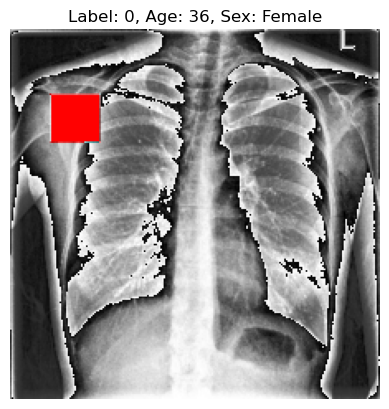

In [8]:
import torchvision.transforms.functional as TF

img, label, age, sex = train_dataset[0]

if isinstance(img, torch.Tensor):
    img_show = TF.to_pil_image(img)
else:
    img_show = img

plt.imshow(img_show)
plt.title(f"Label: {int(label.item())}, Age: {int(age.item())}, Sex: {'Male' if sex.item() == 1.0 else 'Female'}")
plt.axis('off')
plt.show()

In [10]:
from train import train_target
from torchvision.models import resnet18, ResNet18_Weights

target_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
features = target_model.fc.in_features
target_model.fc = nn.Linear(features, 1) # binary classification
target_model.to(mps_device)

target_optimizer = optim.Adam(target_model.parameters(), lr=1e-4)
target_criterion = nn.BCEWithLogitsLoss()

trained_model, train_history = train_target(
    model=target_model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=target_criterion,
    optimizer=target_optimizer,
    num_epochs=10,
    device=mps_device,
    save_path='models/chest2d_cnn_overfit_feats.pt',
    verbose=True
)

Epoch 1/10: Loss = 0.6989, Train Acc = 0.5625, Val Acc = 0.1250, Val AUC (avg) = 0.1667
Epoch 2/10: Loss = 0.6360, Train Acc = 0.7188, Val Acc = 0.2500, Val AUC (avg) = 0.0833
Epoch 3/10: Loss = 0.5412, Train Acc = 0.7500, Val Acc = 0.1250, Val AUC (avg) = 0.0000
Epoch 4/10: Loss = 0.4671, Train Acc = 1.0000, Val Acc = 0.5000, Val AUC (avg) = 0.3333
Epoch 5/10: Loss = 0.3970, Train Acc = 1.0000, Val Acc = 0.5000, Val AUC (avg) = 0.1667
Epoch 6/10: Loss = 0.3431, Train Acc = 1.0000, Val Acc = 0.5000, Val AUC (avg) = 0.5000
Epoch 7/10: Loss = 0.2990, Train Acc = 1.0000, Val Acc = 0.2500, Val AUC (avg) = 0.0833
Epoch 8/10: Loss = 0.2572, Train Acc = 1.0000, Val Acc = 0.3750, Val AUC (avg) = 0.1667
Epoch 9/10: Loss = 0.2195, Train Acc = 1.0000, Val Acc = 0.2500, Val AUC (avg) = 0.0833
Epoch 10/10: Loss = 0.1893, Train Acc = 1.0000, Val Acc = 0.3750, Val AUC (avg) = 0.3333
